In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_core  # Importing RPS_core class from rps_base.py
from rps_simulation.rps_multirun import RPS_multirun # Importing RPS_Multirun class, used for main plots

from rps_simulation.learning_curves import exponential_learning, logistic_learning # learonning curves
from rps_simulation.forgetting_curves import exponential_forgetting  # forgetting curves
from rps_simulation.practice_rate import simple_linear_rate  # simple linear rate
from rps_simulation.waiting_times import exponential_waiting_time  # exp waiting time distributi


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved




In [2]:
# Helper Functions:
def logis(x):
    out = 1/(1 + np.exp(-x))
    return out

def log_odds(p):
    out = np.log(p/(1-p))
    return out


## 1. Individual Differences
Parameters for individual learners are drawn as follows:
* Learning rate $\alpha \sim  U(0.4, 0.8)$
* Forgetting rate $\beta \sim U(0.1, 0.3)$
* Minimum practice rate, $a \sim U(0.1, 0.3)$ 
* Success Sensitivity, $ b \sim U(3, 7)$ 
* Maximum Skill $S_{max} \sim U(0.5, 1)$


We use both logistic and exponential learning curves - once for each learner. 


In [3]:
np.random.seed(10) #setting seed for reproducible results 

# Hyperparameters:
n_agents = 1000 # Number of learners in the simulation
max_time = 500 # Maximum time for each simulation


# parameters varied:
alphas = np.random.uniform(low=0.4, high=0.8, size=n_agents) # learning rates
betas = np.random.uniform(low=0.1, high=0.3, size=n_agents) # forgetting rates

ass = np.random.uniform(low=0.1, high=0.3, size=n_agents) # min. practice rates
bs = np.random.uniform(low=3, high=7, size=n_agents) # success sensitivity

skill_maxs = np.random.uniform(low=0.5, high=1, size=n_agents) # Maximum skill levels

# Constant parameters:
prac_rate0s = np.repeat(1, n_agents) # Initial practice rates
S0s = np.repeat(0.1, n_agents) # initial skills

# lists for saving data
# logistic LC:
S_finals_log = [] # final skills
PE_tots_log = [] # total practice events
S_at_quit_log = [] # skill at quitting time
practime_cache_log = [] # all prac times per learner
skills_cache_log = []  # all skill levels per learner

# exponential LC:
S_finals_exp = [] # final skills
PE_tots_exp = [] # total practice events
S_at_quit_exp = [] # skill at quitting time


# loop over learners and run simulation:
for i in range(n_agents):
    LC_log = logistic_learning(alpha=alphas[i], skill_max=skill_maxs[i]) # logistic LC
    LC_exp = exponential_learning(alpha=alphas[i], skill_max=skill_maxs[i]) # exponential LC
    F_exp = exponential_forgetting(betas[i]) # forgetting curve 
    PR_simple = simple_linear_rate(a=ass[i], b=bs[i]) # practice rate

    # Simulate learning of agent i on logistic LC: 
    model_log = RPS_core(learning_func=LC_log,
                      forgetting_func=F_exp,
                      practice_rate_func=PR_simple,
                      waiting_time_dist=exponential_waiting_time,
                      initial_skill=S0s[i],
                      initial_practice_rate=prac_rate0s[i],
                      max_time=max_time)
    
    model_log.run_simulation()

    # Simulate learning of agent i on exponential LC: 
    model_exp = RPS_core(learning_func=LC_exp,
                      forgetting_func=F_exp,
                      practice_rate_func=PR_simple,
                      waiting_time_dist=exponential_waiting_time,
                      initial_skill=S0s[i],
                      initial_practice_rate=prac_rate0s[i],
                      max_time=max_time)
    
    model_exp.run_simulation()


    # Store sim data:
    S_finals_log.append(model_log.final_skill)
    PE_tots_log.append(model_log.total_practice_events)  
    S_at_quit_log.append(model_log.skill_levels[-2])  
    practime_cache_log.append(model_log.practice_times) 
    skills_cache_log.append(model_log.skill_levels) 

    S_finals_exp.append(model_exp.final_skill)
    PE_tots_exp.append(model_exp.total_practice_events)  
    S_at_quit_exp.append(model_exp.skill_levels[-2])  


    

# Make dataframe:
df_log_ID = pd.DataFrame({'S_finals': S_finals_log, 
                            'PE_tots':PE_tots_log, 
                            'S_at_quit': S_at_quit_log})

# Make dataframe:
df_exp_ID = pd.DataFrame({'S_finals': S_finals_exp, 
                            'PE_tots':PE_tots_exp, 
                            'S_at_quit': S_at_quit_exp})

df_ID_combined = pd.concat([df_log_ID, df_exp_ID], axis=0, ignore_index=True)





### 1.1 Combined Plots: 



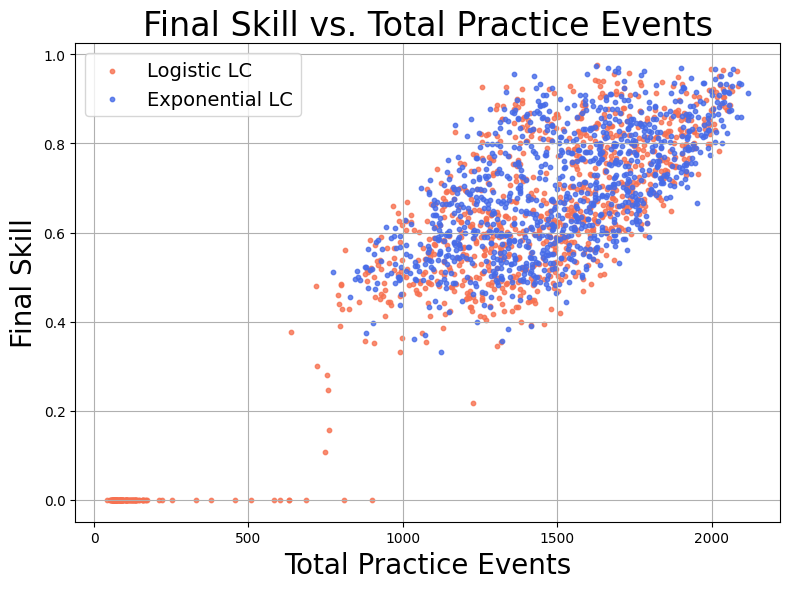

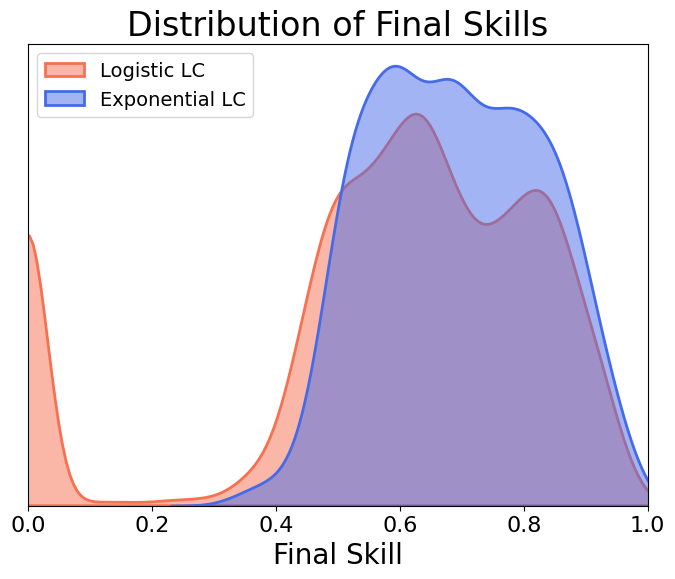

In [4]:

# ----- Plotting -------
dotsize=10


## --- Scatter plot - final skill vs. total practice events ------
plt.figure(figsize=(8, 6))  

# plot logistic LC data
plt.scatter(df_log_ID['PE_tots'], df_log_ID['S_finals'], s=10, color=sigmoid_colour, alpha=0.8)

# plot exponential LC data
plt.scatter(df_exp_ID['PE_tots'], df_exp_ID['S_finals'], s=10, color=concave_colour, alpha=0.8)

plt.title('Final Skill vs. Total Practice Events', fontsize=24)
plt.ylabel('Final Skill', fontsize=20)
plt.xlabel('Total Practice Events', fontsize=20)
plt.legend(labels=['Logistic LC', 'Exponential LC'], fontsize=14)
#plt.xlim(0, 1)
#plt.ylim(0, 100)
plt.grid(True)
plt.savefig('../plots/all_ID_Sf_vs_Ptot.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.tight_layout()
plt.show()




# ------ Distribution of Final Skills ------
plt.figure(figsize=(8, 6))

# Create the distribution plot
sns.kdeplot(
    data=df_log_ID['S_finals'],
    color=sigmoid_colour,
    fill=True,
    alpha=0.5,
    linewidth=2,
    bw_adjust=0.5
)


# Create the distribution plot
sns.kdeplot(
    data=df_exp_ID['S_finals'],
    color=concave_colour,
    fill=True,
    alpha=0.5,
    linewidth=2,
    bw_adjust=1
)

# tick-params:
plt.tick_params(left = True, right = False , labelleft = True)
plt.xticks(fontsize=16)
plt.xlim([0,1])
plt.yticks([], fontsize=16)
plt.ylabel('', fontsize=20)
plt.xlabel('Final Skill', fontsize=20)
plt.title('Distribution of Final Skills', fontsize=24)
plt.legend(labels=['Logistic LC', 'Exponential LC'], fontsize=14, loc='upper left')
plt.savefig('../plots/all_ID_Sf_dist.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()



### 1.2 Other Logistic Plots:

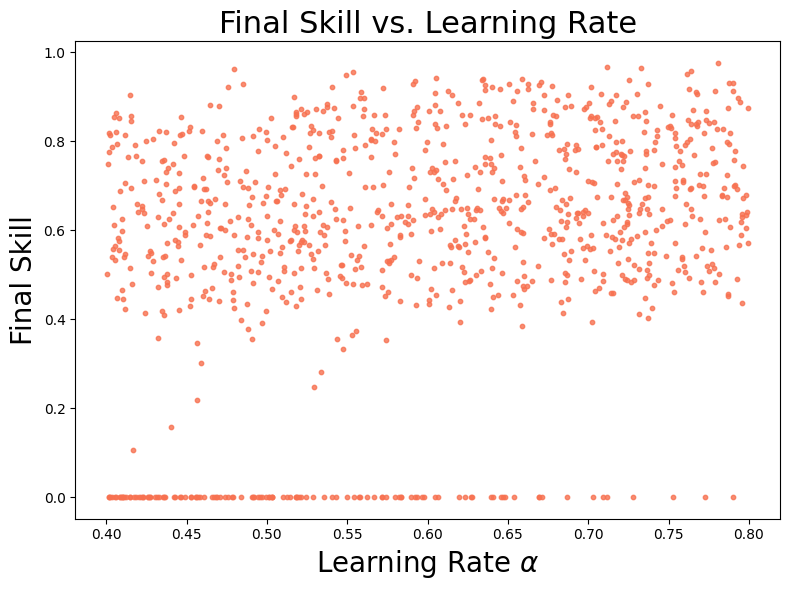

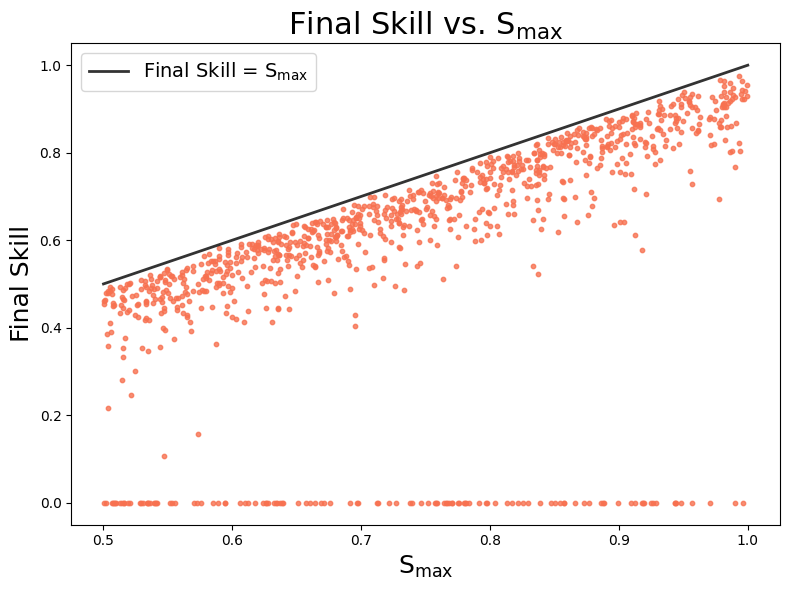

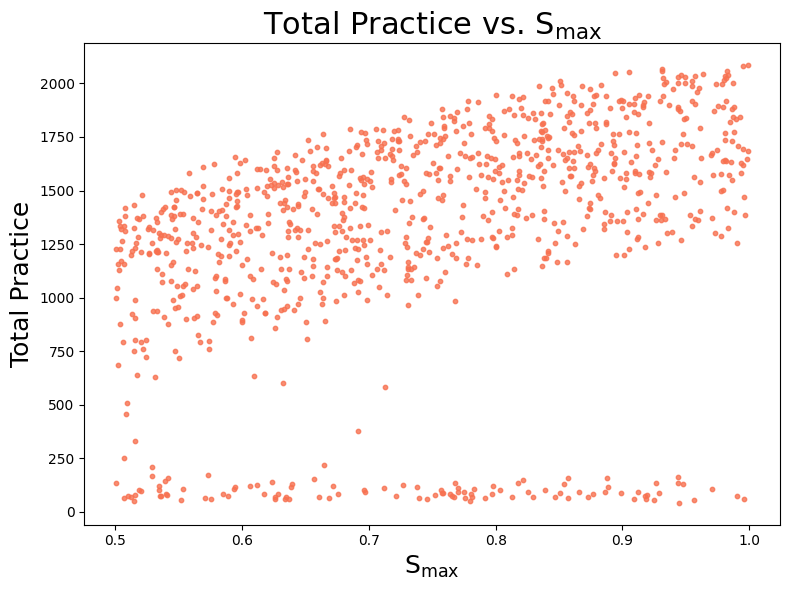

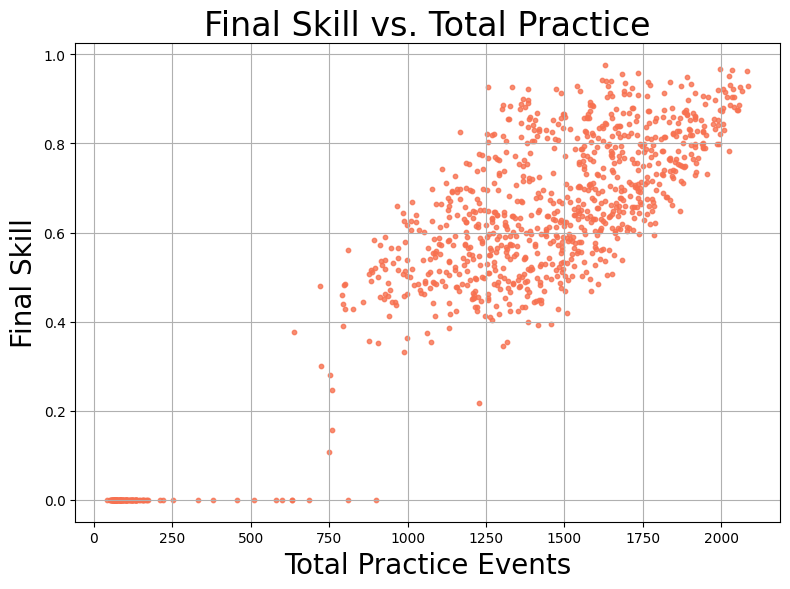

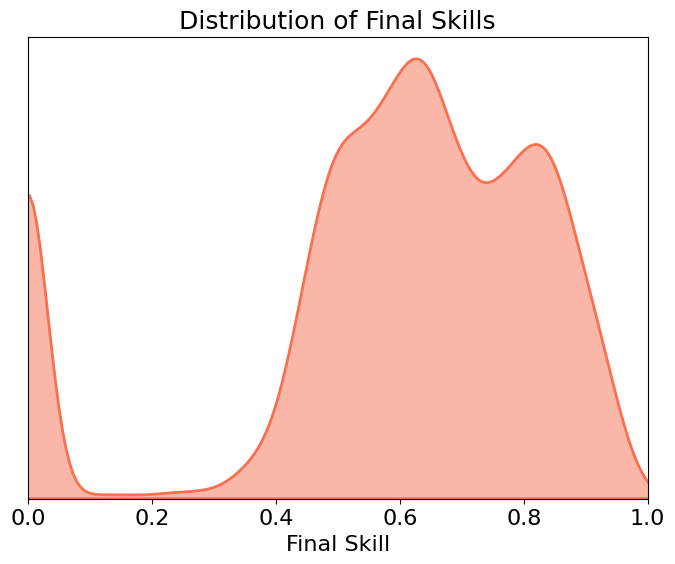

In [5]:


# ---- 1. Final Skill vs. Learning rate  ----
plt.figure(figsize=(8, 6))
plt.scatter(alphas, S_finals_log, s=dotsize, 
            color=sigmoid_colour, alpha=0.8)
plt.title('Final Skill vs. Learning Rate', fontsize=22)
plt.xlabel(r'Learning Rate $\alpha$', fontsize=20)
plt.ylabel('Final Skill', fontsize=20)
plt.tight_layout()
plt.savefig('../plots/log_ID_Sf_vs_alpha.jpg',
             dpi=plot_dpi, bbox_inches='tight')
plt.show()



# ----- 2. Final Skill vs. S_max ------- 
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, S_finals_log, s=dotsize, alpha=0.8, color=sigmoid_colour)
plt.plot([0.5, 1], [0.5, 1], color='black', lw=2, alpha=0.8, ls='-', 
            label= r'Final Skill = $\mathrm{S_{max}}$') # S_max line
plt.title(r'Final Skill vs. $\mathrm{S_{max}}$',  fontsize=22)
plt.xlabel(r'$\mathrm{S_{max}}$', fontsize=18)
plt.ylabel('Final Skill',  fontsize=18)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('../plots/log_ID_Sf_vs_Smax.jpg', 
            dpi=plot_dpi, bbox_inches='tight')
plt.show()


# ---- 3. S_max vs. Tot. Practice Events ----
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, PE_tots_log, s=dotsize, alpha=0.8, color=sigmoid_colour)
plt.title(r'Total Practice vs. $\mathrm{S_{max}}$', fontsize=22)
plt.xlabel(r'$\mathrm{S_{max}}$', fontsize=18)
plt.ylabel('Total Practice',  fontsize=18)
plt.tight_layout()
plt.savefig('../plots/log_ID_Ptot_vs_Smax.jpg', 
            dpi=plot_dpi, bbox_inches='tight')
plt.show()




## --- 4. Scatter plot - final skill vs. total practice events ------
plt.figure(figsize=(8, 6))  
plt.scatter(df_log_ID['PE_tots'], df_log_ID['S_finals'], 
            s=10, color=sigmoid_colour, alpha=0.8)
plt.title('Final Skill vs. Total Practice', fontsize=24)
plt.ylabel('Final Skill', fontsize=20)
plt.xlabel('Total Practice Events', fontsize=20)
plt.grid(True)
plt.savefig('../plots/log_ID_Sf_vs_Ptot.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.tight_layout()
plt.show()




# ------ 5. Distribution of Final Skills ------
plt.figure(figsize=(8, 6))

# Create the distribution plot
sns.kdeplot(
    data=df_log_ID['S_finals'],
    color=sigmoid_colour,
    fill=True,
    alpha=0.5,
    linewidth=2,
    bw_adjust=0.5
)


# tick-params:
plt.tick_params(left = True, right = False , labelleft = True)
plt.xticks(fontsize=16)
plt.xlim([0,1])
plt.yticks([], fontsize=16)
plt.ylabel('', fontsize=16)
plt.xlabel('Final Skill', fontsize=16)
plt.title('Distribution of Final Skills', fontsize=18)
plt.savefig('../plots/log_ID_Sf_dist.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()

 

### 1.3 Other Exponential Plots:


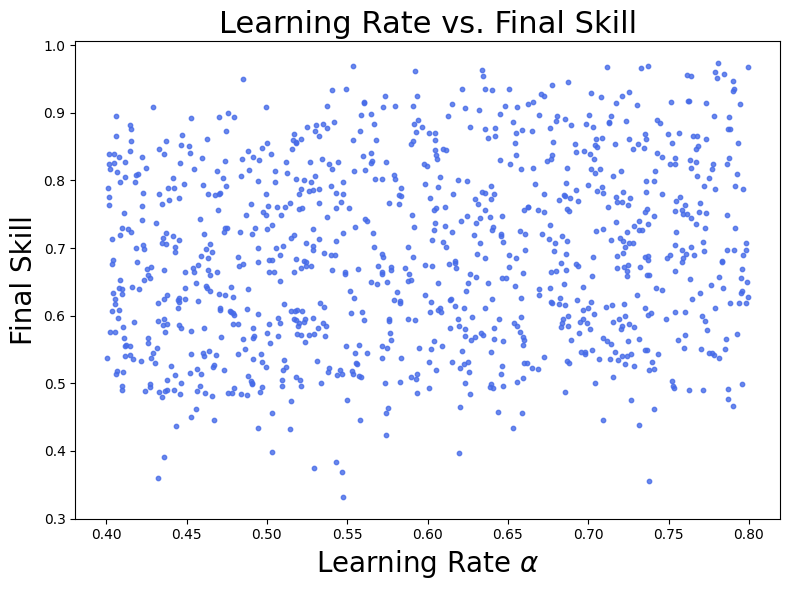

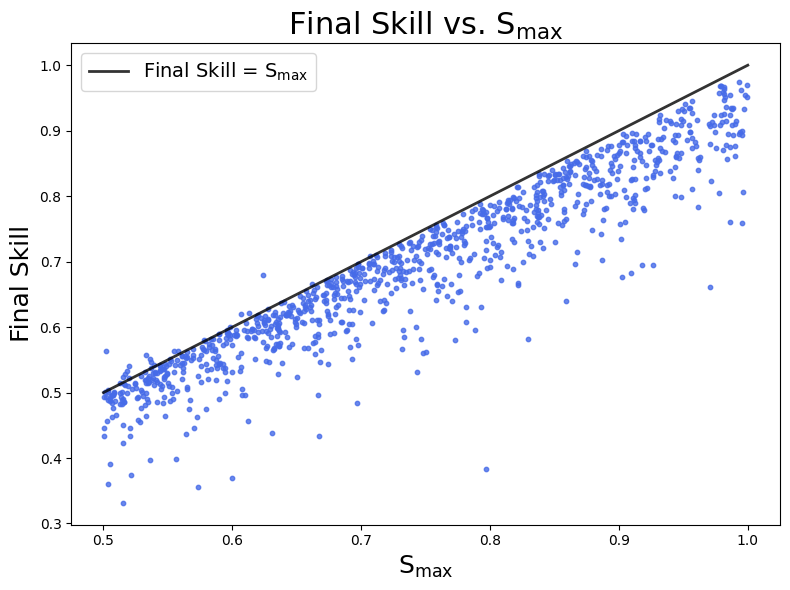

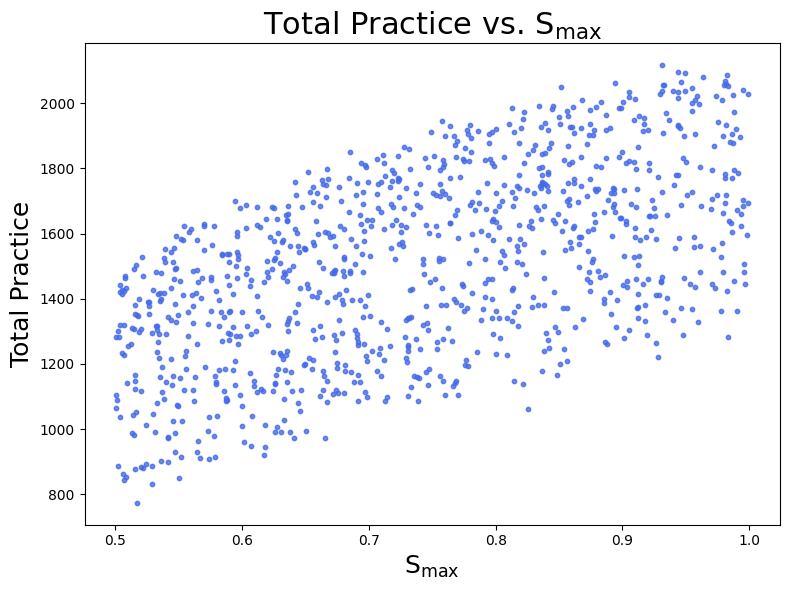

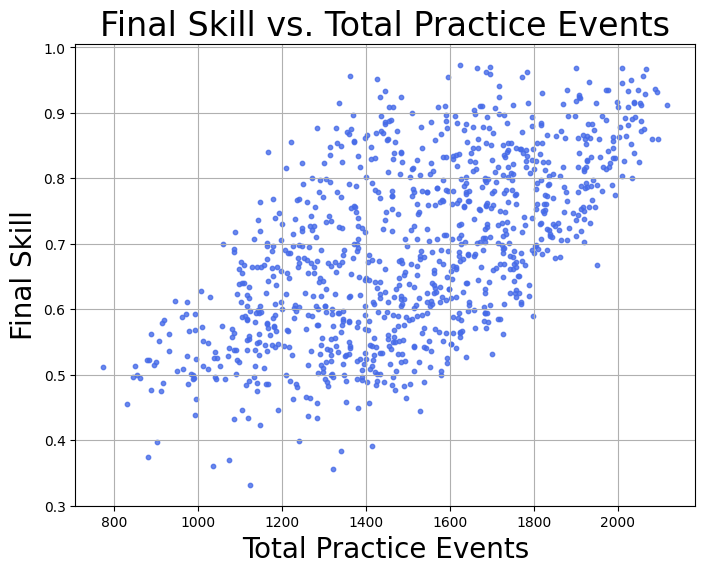

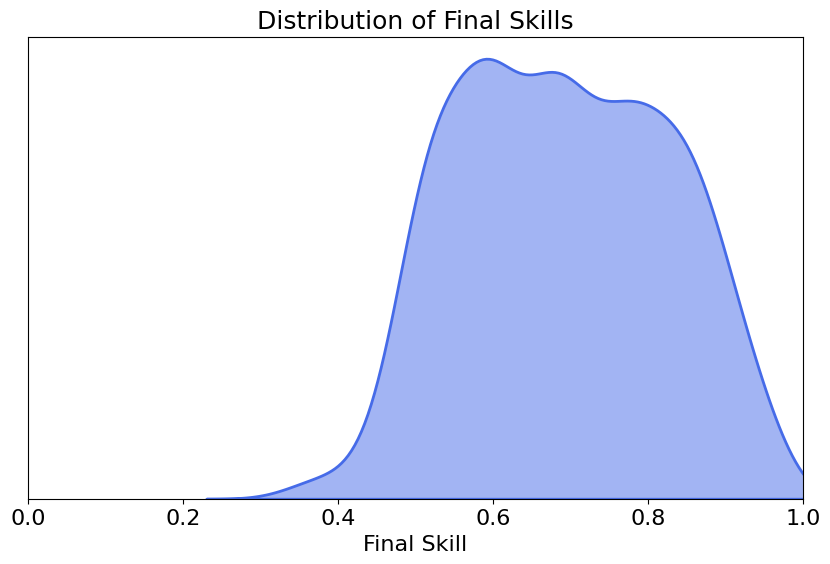

In [6]:

# ----- Plotting -------
dotsize=10


# ---- S_final vs. Learning Rate  ----
# Learning rate vs. Final Skill
plt.figure(figsize=(8, 6))
plt.scatter(alphas, S_finals_exp, s=dotsize, color=concave_colour, alpha=0.8)
plt.title('Learning Rate vs. Final Skill', fontsize=22)
plt.xlabel(r'Learning Rate $\alpha$', fontsize=20)
plt.ylabel('Final Skill', fontsize=20)
plt.tight_layout()
plt.show()


# ----- # S_max vs. Final Skill ------- 
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, S_finals_exp, s=dotsize, alpha=0.8, color=concave_colour)
plt.plot([0.5, 1], [0.5, 1], color='black', lw=2, alpha=0.8, ls='-', 
            label= r'Final Skill = $\mathrm{S_{max}}$') # S_max line
plt.title(r'Final Skill vs. $\mathrm{S_{max}}$',  fontsize=22)
plt.xlabel(r'$\mathrm{S_{max}}$', fontsize=18)
plt.ylabel('Final Skill',  fontsize=18)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('../plots/exp_ID_Sf_vs_Smax.jpg', 
            dpi=plot_dpi, bbox_inches='tight')
plt.show()

# S_max vs. Tot. Practice Events
plt.figure(figsize=(8, 6))
plt.scatter(skill_maxs, PE_tots_exp, s=dotsize, color=concave_colour, alpha=0.8)
plt.title(r'Total Practice vs. $\mathrm{S_{max}}$', fontsize=22)
plt.xlabel(r'$\mathrm{S_{max}}$', fontsize=18)
plt.ylabel('Total Practice',  fontsize=18)
plt.tight_layout()
plt.show()




## --- Scatter plot - final skill vs. total practice events ------
plt.figure(figsize=(8, 6))  
plt.scatter(df_exp_ID['PE_tots'], df_exp_ID['S_finals'], 
            s=10, color=concave_colour, alpha=0.8)
plt.title('Final Skill vs. Total Practice Events', fontsize=24)
plt.ylabel('Final Skill', fontsize=20)
plt.xlabel('Total Practice Events', fontsize=20)
#plt.xlim(0, 1)
#plt.ylim(0, 100)
plt.grid(True)
plt.savefig('../plots/exp_ID_Sf_vs_Ptot.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()



# ------ Distribution of Final Skills ------
plt.figure(figsize=(10, 6))

# Create the distribution plot
sns.kdeplot(
    data=df_exp_ID['S_finals'],
    color=concave_colour,
    fill=True,
    alpha=0.5,
    linewidth=2,
    #bw_adjust=bw_adjust
    bw_adjust=1
)


# tick-params:
plt.tick_params(left = True, right = False , labelleft = True)
plt.xticks(fontsize=16)
plt.xlim([0,1])
plt.yticks([], fontsize=16)
plt.ylabel('', fontsize=16)
plt.xlabel('Final Skill', fontsize=16)
plt.title('Distribution of Final Skills', fontsize=18)

plt.savefig('../plots/exp_ID_Sf_dist.jpg', dpi=plot_dpi, bbox_inches='tight')
plt.show()

 


## 2. Add Random Quitting 

### 2.1 Random Quitting at Practice Events
We simulate a more realistic scenario where learners may also quit for other reasons. We model this as a constant small probability $p_{rquit} > 0$  to quit after every practice event. Without other ways of quitting, this would result in a geometric distribution of total practice-events before quitting. 

Now we add random quitting to the logistic LC simulated above with individual differences. We compare the quitting hazard rates in this scenario with real data.


In [7]:
# k = [practime_cache_log[0][i] - practime_cache_log[0][i-1] for i in range(1, len(practime_cache_log[0]))]
# print(k[:10])

# plot first vals in prac times list:
#print(practime_cache_log[0][:10])

def find_quittime(prac_times, quit_thresh=10):
    """
    Find total practice events before quitting. 
    Here, quitting is defined as the first time when wait-time exceeds a threshold.

    Parameters:
    -----------
    prac-times: list of practice times as generated by RPS_core
    quit_thresh : sets definition of quitting
    
    Returns:
    --------
    Total practice events before quitting or -1 if not quit
    """

    # first get wait-times list:
    n_prac = len(prac_times) # length of practice times list
    wait_times = [prac_times[i] - prac_times[i-1] for i in range(1, n_prac)]

    for i, value in enumerate(wait_times):
        if value > quit_thresh:
            return i # i >=0 if quitting occurs on practice i
    
    return -1 # -1 if no quitting

### 2.1 Plot Logistic Sim Hazard Rate

We use the _muhaz_ R-package to estimate quitting hazard rates from the saved  _df_rquit_sigmoid_ dataframe, in the _'R code/haz_rate_sim.R'_ file. The estimated hazard rates are saved. We import and plot them for the paper below.  

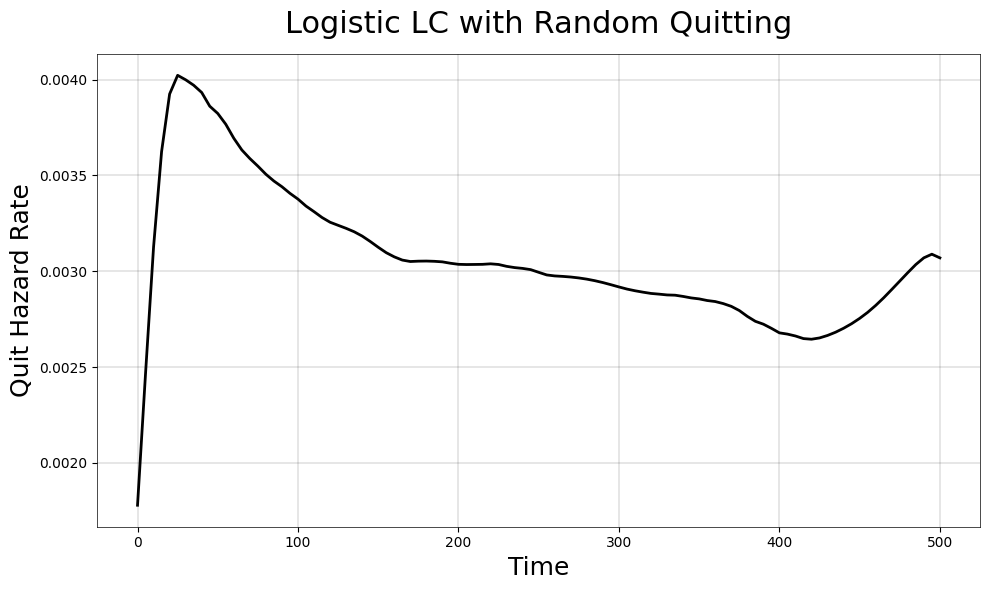

In [8]:
log_ID_haz_rates = pd.read_csv('../data/sim_log_haz_rates.csv') # estimated using Muhaz R-package

# Set style to white background
plt.style.use('default')

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=log_ID_haz_rates, 
            x='time', 
            y='haz_rate', 
            color='black',
            linewidth=2)

# Customize the plot
plt.title('Logistic LC with Random Quitting', fontsize=22, pad=15)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Quit Hazard Rate', fontsize=18)


# Customize grid
plt.grid(True, color='black', linestyle='-', linewidth=0.2, alpha=0.7)

# White background with thin black border
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.5)


# Adjust layout
plt.tight_layout()
plt.savefig('../plots/sim_log_ID_haz_rate.jpg', dpi=512)
plt.show()


## 3. Han's Plot:

In [9]:
# Function to create PE_tots bins
def create_pe_bins(df, n_bins=5):
    """
    Create equal-sized bins for PE_tots values
    """
    # Create bins using pd.cut
    df_copy = df.copy()
    df_copy['PE_tots_binned'] = pd.cut(df_copy['PE_tots'], 
                                       bins=n_bins, 
                                       include_lowest=True,
                                       precision=0)
    
    # Create readable labels for the bins
    bin_labels = []
    for interval in df_copy['PE_tots_binned'].cat.categories:
        left = int(interval.left)
        right = int(interval.right)
        bin_labels.append(f"{left}-{right}")
    
    # Replace the interval objects with string labels
    df_copy['PE_tots_bin_label'] = df_copy['PE_tots_binned'].astype(str)
    for i, interval in enumerate(df_copy['PE_tots_binned'].cat.categories):
        df_copy.loc[df_copy['PE_tots_binned'] == interval, 'PE_tots_bin_label'] = bin_labels[i]
    
    return df_copy




# Method 1: Smoothed Density Plots (KDE) with binned PE_tots
def plot_density_by_bins(df, n_bins=5, figsize=(12, 8)):
    """
    Create density plots grouped by PE_tots bins
    """
    # Create binned data
    df_binned = create_pe_bins(df, n_bins)
    
    # Get unique bins and sort them
    unique_bins = df_binned['PE_tots_bin_label'].unique()
    # Sort by the lower bound of each bin
    unique_bins = sorted(unique_bins, key=lambda x: int(x.split('-')[0]))
    
    # Create subplots
    n_rows = int(np.ceil(n_bins / 2))
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize, sharex=True)
    if n_bins <= 2:
        axes = [axes] if n_bins == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, bin_label in enumerate(unique_bins):
        ax = axes[i] if n_bins > 1 else axes
        
        # Filter data for current bin
        bin_data = df_binned[df_binned['PE_tots_bin_label'] == bin_label]['S_at_quit']
        
        # Create KDE plot
        sns.kdeplot(data=bin_data, ax=ax, fill=True, alpha=0.7, color='gray')
        
        # Customize subplot
        ax.set_title(f'PE_tots: {bin_label}', fontsize=12)
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    if n_bins > 1:
        for j in range(len(unique_bins), len(axes)):
            axes[j].set_visible(False)
    
    plt.xlabel('S_final (Final Skill)')
    plt.suptitle('Distribution of Final Skill by Practice Total (Binned)', fontsize=14)
    plt.tight_layout()
    plt.show()



plot_density_by_bins(df_rquit_sigmoid, n_bins=8)

NameError: name 'df_rquit_sigmoid' is not defined